In [1]:
import numpy as np
import multiprocessing as mp
from xclib.data import data_utils
import scipy
import math  
from tqdm import tqdm
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
path = input()
trainX = data_utils.read_sparse_file(path+"/train_x.txt").toarray()
trainY = np.loadtxt(path+"/train_y.txt")
testX = data_utils.read_sparse_file(path+"/test_x.txt").toarray()
testY = np.loadtxt(path+"/test_y.txt")
valX = data_utils.read_sparse_file(path+"/valid_x.txt").toarray()
valY = np.loadtxt(path+"/valid_y.txt")

../../virus/Adata


/home/kartik/.local/lib/python3.7/site-packages/xclib-0.96-py3.7-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [3]:
class Node:
    def __init__(self,attr,splitVal,value,n,left,right,parent):
        self.left = left
        self.right = right
        self.parent = parent
        self.attr = attr
        self.splitVal = splitVal
        self.majority = value
        self.nodeCount = n
        
class DecisionTree:
    def __init__(self):
        return

    def traverseTree(self,x,node):
        if(node.left==None and node.right==None):
            return node.majority
        if(x[node.attr]<=node.splitVal):
            return self.traverseTree(x,node.left)
        return self.traverseTree(x,node.right)

    def predict(self,dataX):
        predictions = []
        for i in dataX:
            predictions.append(self.traverseTree(i,self.root))
        predictions = np.array(predictions)
        return predictions

    def chooseBestAttr(self,dataX,dataY):
        pos = np.sum(dataY==1)
        neg = dataY.shape[0]-pos
        HY = -(pos/dataY.shape[0])*math.log(pos/dataY.shape[0])-(neg/dataY.shape[0])*math.log(neg/dataY.shape[0])
        entropyList=[]
        median = np.median(dataX,axis=0)
        for i in (range(dataX.shape[1])):
            splitVal = median[i]
            indices0 = np.where(dataX[:,i] <= splitVal)[0]
            indices1 = np.where(dataX[:,i] > splitVal)[0]
            if(indices0.shape[0]==0 or indices1.shape[0]==0):
                entropyList.append(0)
                continue

            Y0 = dataY[indices0]
            Y1 = dataY[indices1]
            pos = np.sum(Y0)
            neg = Y0.shape[0]-pos
            if(pos==0 or neg==0):
                H0=0
            else:
                H0 = -(pos/Y0.shape[0])*math.log(pos/Y0.shape[0])-(neg/Y0.shape[0])*math.log(neg/Y0.shape[0])
            H0 = (indices0.shape[0]/dataX.shape[0])*H0
            pos = np.sum(Y1)
            neg = Y1.shape[0]-pos
            if(pos==0 or neg==0):
                H1=0
            else:
                H1 = -(pos/Y1.shape[0])*math.log(pos/Y1.shape[0])-(neg/Y1.shape[0])*math.log(neg/Y1.shape[0])
            H1 = (indices1.shape[0]/dataX.shape[0])*H1
            entropyList.append(HY-H0-H1)
        if(sum(entropyList)==0):
            attr = entropyList.index(max(entropyList))
            splitVal = median[i]
            indices0 = np.where(dataX[:,i] <= splitVal)[0]
            indices1 = np.where(dataX[:,i] > splitVal)[0]
            if indices0.shape[0]==0 or indices1.shape[0]==0:
                return -1
        return entropyList.index(max(entropyList))
    
    def growTree(self,dataX,dataY,testX,testY,valX,valY,interval):
        queue = [(self.root,dataX,dataY,testX,testY,valX,valY)]
        count = 0
        tTrain,tTest,tVal = dataY.shape[0],testY.shape[0],valY.shape[0]
        if(self.root.majority==1):
            cTrain,cTest,cVal = np.sum(dataY),np.sum(testY),np.sum(valY)
        else:
            cTrain,cTest,cVal = np.sum(1-dataY),np.sum(1-testY),np.sum(1-valY)
        # nodeCount,trainList,testList,valList = [1],[cTrain/tTrain],[cTest/tTest],[cVal/tVal]
        nodeCount,trainList,testList,valList = [],[],[],[]
        while(len(queue)!=0):
            c = (queue[-1])[0].nodeCount
            x,DX,DY,TX,TY,VX,VY = queue.pop(0)
            s = np.sum(DY)
            if(s == DY.shape[0]):
                continue
            if(s == 0):
                continue
            attr = self.chooseBestAttr(DX,DY)
            if(attr == -1):
                continue   
            if(s > DY.shape[0]/2):
                val=1
                cTrain = cTrain - np.sum(DY)
                cTest = cTest - np.sum(TY)
                cVal = cVal - np.sum(VY)
            else:
                val=0
                cTrain = cTrain - np.sum(1-DY)
                cTest = cTest - np.sum(1-TY)
                cVal = cVal - np.sum(1-VY)

            seq = DX[:,attr]
            splitVal = np.median(seq)
            indices0 = np.where(DX[:,attr] <= splitVal)[0]
            indices1 = np.where(DX[:,attr] > splitVal)[0]
            D0,Y0 = DX[indices0,:],DY[indices0]
            D1,Y1 = DX[indices1,:],DY[indices1]

            indices0 = np.where(TX[:,attr] <= splitVal)[0]
            indices1 = np.where(TX[:,attr] > splitVal)[0]
            TX0,TY0 = TX[indices0,:],TY[indices0]
            TX1,TY1 = TX[indices1,:],TY[indices1]

            indices0 = np.where(VX[:,attr] <= splitVal)[0]
            indices1 = np.where(VX[:,attr] > splitVal)[0]
            VX0,VY0 = VX[indices0,:],VY[indices0]
            VX1,VY1 = VX[indices1,:],VY[indices1]

            x.attr,x.splitVal,x.majority = attr,splitVal,val

            s = np.sum(Y0)
            if(s > Y0.shape[0]/2):
                v = 1
                cTrain = cTrain + np.sum(Y0)
                cTest = cTest + np.sum(TY0)
                cVal = cVal + np.sum(VY0)
            else:
                v = 0
                cTrain = cTrain + np.sum(1-Y0)
                cTest = cTest + np.sum(1-TY0)
                cVal = cVal + np.sum(1-VY0)
            left = Node(-1,-1,v,c+1,None,None,x)

            s = np.sum(Y1)
            if(s > Y1.shape[0]/2):
                v = 1
                cTrain = cTrain + np.sum(Y1)
                cTest = cTest + np.sum(TY1)
                cVal = cVal + np.sum(VY1)
            else:
                v = 0
                cTrain = cTrain + np.sum(1-Y1)
                cTest = cTest + np.sum(1-TY1)
                cVal = cVal + np.sum(1-VY1)
            right = Node(-1,-1,v,c+2,None,None,x)

            x.left,x.right = left,right
            queue.append((left,D0,Y0,TX0,TY0,VX0,VY0))
            queue.append((right,D1,Y1,TX1,TY1,VX1,VY1))
            count+=1

            if(count%interval==0):
                nodeCount.append(c+2)
                trainList.append(cTrain/tTrain)
                testList.append(cTest/tTest)
                valList.append(cVal/tVal)
        return nodeCount,trainList,testList,valList

    def fit(self,trainX,trainY,testX,testY,valX,valY,interval):
        s = np.sum(trainY)
        if(s > trainY.shape[0]/2):
            v = 1
        else:
            v = 0
        self.root = Node(-1,-1,v,0,None,None,None)
        nodeCount,trainList,testList,valList = self.growTree(trainX,trainY,testX,testY,valX,valY,interval)
        return nodeCount,trainList,testList,valList

    def findDepth(self,root):
        if(root==None):
            return 0
        return max(self.findDepth(root.left),self.findDepth(root.right))+1
    
    def countNodes(self,root):
        if(root==None):
            return 0
        l = self.countNodes(root.left)
        r = self.countNodes(root.right)
        return l+r+1
    
    def score(self,pred,dataY):
        check = (pred==dataY)
        return np.sum(check)/dataY.shape[0]

    def checkBinary(self,root):
        if(root.left==None and root.right==None):
            return 1
        if(root.left!=None and root.right==None):
            return 0
        if(root.left==None and root.right!=None):
            return 0

        return self.checkBinary(root.left) and self.checkBinary(root.right)

    def countLeaves(self,root):
        if(root.left==None and root.right==None):
            return 1
        return self.countLeaves(root.left)+self.countLeaves(root.right)
    
    def findNodes(self,Xtrain,Ytrain,Xtest,Ytest,Xval,Yval):
        queue = [(self.root,Xtrain,Ytrain,Xtest,Ytest,Xval,Yval)]
        nodeList,leafList = {},{}
        while(len(queue)!=0):
            x,trainX,trainY,testX,testY,valX,valY = queue.pop(0)
            attr = x.attr
            splitVal = x.splitVal
            nodeList[x.nodeCount] = (x,trainX,trainY,testX,testY,valX,valY)

            if(x.left==None and x.right==None):
                leafList[x.nodeCount] = (x,trainX,trainY,testX,testY,valX,valY)
                continue
            
            indices0 = np.where(trainX[:,attr] <= splitVal)[0]
            indices1 = np.where(trainX[:,attr] > splitVal)[0]
            trainX0,trainY0 = trainX[indices0,:],trainY[indices0]
            trainX1,trainY1 = trainX[indices1,:],trainY[indices1]

            indices0 = np.where(testX[:,attr] <= splitVal)[0]
            indices1 = np.where(testX[:,attr] > splitVal)[0]
            testX0,testY0 = testX[indices0,:],testY[indices0]
            testX1,testY1 = testX[indices1,:],testY[indices1]

            indices0 = np.where(valX[:,attr] <= splitVal)[0]
            indices1 = np.where(valX[:,attr] > splitVal)[0]
            valX0,valY0 = valX[indices0,:],valY[indices0]
            valX1,valY1 = valX[indices1,:],valY[indices1]

            queue.append((x.left,trainX0,trainY0,testX0,testY0,valX0,valY0))
            queue.append((x.right,trainX1,trainY1,testX1,testY1,valX1,valY1))
        return nodeList,leafList

    def checkLeaf(self,root,number):
        if(root.nodeCount == number):
            if(root.left==None and root.right==None):
                return 1
            return 0
        if(root.left==None and root.right==None):
            return 1
        return self.checkLeaf(root.left,number) and self.checkLeaf(root.right,number)

    def pruneNodes(self,root,nodeList,total,cTrain,cTest,cVal,accList,trainTotal,testTotal,valTotal):
        if(root.left==None and root.right==None):
            if(root.majority == 1):
                correctVal = np.sum(nodeList[root.nodeCount][6])
                correctTest = np.sum(nodeList[root.nodeCount][4])
                correctTrain = np.sum(nodeList[root.nodeCount][2])
            else:
                correctVal = np.sum(1-nodeList[root.nodeCount][6])
                correctTest = np.sum(1-nodeList[root.nodeCount][4])
                correctTrain = np.sum(1-nodeList[root.nodeCount][2])
            return 1,correctVal,correctTest,correctTrain,accList,cTrain,cTest,cVal,total
        
        leftNodeCount,cLVal,cLTest,cLTrain,accList,cTrain,cTest,cVal,total = self.pruneNodes(root.left,nodeList,total,cTrain,cTest,cVal,accList,trainTotal,testTotal,valTotal)
        rightNodeCount,cRVal,cRTest,cRTrain,accList,cTrain,cTest,cVal,total = self.pruneNodes(root.right,nodeList,total,cTrain,cTest,cVal,accList,trainTotal,testTotal,valTotal)

        if(root.majority == 1):
            cPVal = np.sum(nodeList[root.nodeCount][6])
            cPTest = np.sum(nodeList[root.nodeCount][4])
            cPTrain = np.sum(nodeList[root.nodeCount][2])
        else:
            cPVal = np.sum(1-nodeList[root.nodeCount][6])
            cPTest = np.sum(1-nodeList[root.nodeCount][4])
            cPTrain = np.sum(1-nodeList[root.nodeCount][2])

        rootNodeCount=leftNodeCount+rightNodeCount+1
        if(cPVal >= cLVal+cRVal):
            cTrain = cTrain - cLTrain - cRTrain + cPTrain
            cTest = cTest - cLTest - cRTest + cPTest
            cVal = cVal - cLVal - cRVal + cPVal
            total = total - leftNodeCount - rightNodeCount

            accList.append([total,cTrain/trainTotal,cTest/testTotal,cVal/valTotal])
            root.left,root.right=None,None
            root.attr,root.splitVal=-1,-1
            rootNodeCount=1
            return rootNodeCount,cPVal,cPTest,cPTrain,accList,cTrain,cTest,cVal,total

        return rootNodeCount,cLVal+cRVal,cLTest+cRTest,cLTrain+cRTrain,accList,cTrain,cTest,cVal,total


    def prune(self,trainX,trainY,testX,testY,valX,valY):
        nodeList,leafList = self.findNodes(trainX,trainY,testX,testY,valX,valY)
        total = self.countNodes(self.root)
        correctTrain,correctTest,correctVal = 0,0,0
        for i in list(leafList.keys()):
            if(leafList[i][0].majority==1):
                correctTrain+= np.sum(leafList[i][2])
                correctTest+= np.sum(leafList[i][4])
                correctVal+= np.sum(leafList[i][6])
            else:
                correctTrain+= np.sum(1-leafList[i][2])
                correctTest+= np.sum(1-leafList[i][4])
                correctVal+= np.sum(1-leafList[i][6])
        accList = [[total,correctTrain/trainX.shape[0],correctTest/testX.shape[0],correctVal/valX.shape[0]]]
        self.pruneNodes(self.root,nodeList,total,correctTrain,correctTest,correctVal,accList,trainX.shape[0],testX.shape[0],valX.shape[0])
        return accList

In [4]:
def plotTreeAccuracies(x,train,test,val,title,leg):
    y = np.array(train)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.plot(x,y,label="Train Set Accuracies")
    y = np.array(test)
    ax.plot(x,y,label="Test Set Accuracies")
    y = np.array(val)
    ax.plot(x,y,label="Validation Set Accuracies")
    plt.title(title)
    ax.set_xlabel("Node Count",fontsize=12)
    ax.set_ylabel("Accuracies",fontsize=12)
    plt.legend(loc=leg)
    plt.show()
    
def oobScore(params,data):
    rf = RandomForestClassifier(criterion='entropy',n_estimators=params[0],min_samples_split=params[1],max_features=params[2],oob_score=True,n_jobs=-1)
    rf.fit(data[0],data[1])
    return (params,rf.oob_score_)
    
def scorer(clf,X,y):
    return clf.oob_score_

def findAcc(params,data):
    rf = RandomForestClassifier(criterion='entropy',n_estimators=params[0],min_samples_split=params[1],max_features=params[2],oob_score=True,n_jobs=-1)
    rf.fit(data[0],data[1])
    return (rf.score(data[0],data[1]),rf.score(data[2],data[3]),rf.score(data[4],data[5]))

def paramSensitivity(estimatorList,minSamplesList,maxFeaturesList):
    n_estimators_varied,min_samples_split_varied,max_features_varied = [],[],[]
    data = (trainX,trainY,testX,testY,valX,valY)
    for i in estimatorList:
        n_estimators_varied.append(findAcc((i,best_min_samples_split,best_max_features),data))
    print("estimators",n_estimators_varied)

    for i in minSamplesList:
        min_samples_split_varied.append(findAcc((best_n_estimators,i,best_max_features),data))
    print("min samples split",min_samples_split_varied)


    for i in maxFeaturesList:
        max_features_varied.append(findAcc((best_n_estimators,best_min_samples_split,i),data))
    print("max features",max_features_varied)

    return n_estimators_varied,min_samples_split_varied,max_features_varied

def plotForest(x,y,title,xlabel,leg): 
    y = np.array(y) 
    plt.figure(figsize=(8,6)) 
    ax = plt.gca()

    # ax.plot(x,y[:,0],label="Train Set Accuracies")
    ax.plot(x,y[:,1],label="Test Set Accuracies")
    ax.plot(x,y[:,2],label="Validation Set Accuracies")
    plt.title(title)
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel("Accuracies",fontsize=12)
    plt.legend(loc=leg)
#     plt.savefig(title+".png")
    plt.show()

## PART A

In [5]:
interval = 10
clf = DecisionTree()
try:
    st = time()
    pickle_in = open("Tree.pickle","rb")
    clf,nodeCount,trainList,testList,valList = pickle.load(pickle_in)
    print("Tree Loaded in :",time()-st)
except:
    st = time()
    nodeCount,trainList,testList,valList = clf.fit(trainX,trainY,testX,testY,valX,valY,interval)
    print("Tree created in:",time()-st)
    with open("Tree.pickle", "wb") as f:
        pickle.dump((clf,nodeCount,trainList,testList,valList), f)

Tree Loaded in : 0.25500965118408203


In [6]:
predTrain = clf.predict(trainX)
trainScore = clf.score(predTrain,trainY)
print("Training Score on Tree:",trainScore)
predTest = clf.predict(testX)
testScore = clf.score(predTest,testY)
print("Testing Score on Tree:",testScore)
predVal = clf.predict(valX)
valScore = clf.score(predVal,valY)
print("Validation Score on Tree:",valScore)

Training Score on Tree: 0.9047023009287161
Testing Score on Tree: 0.7797505910713458
Validation Score on Tree: 0.775913220841832


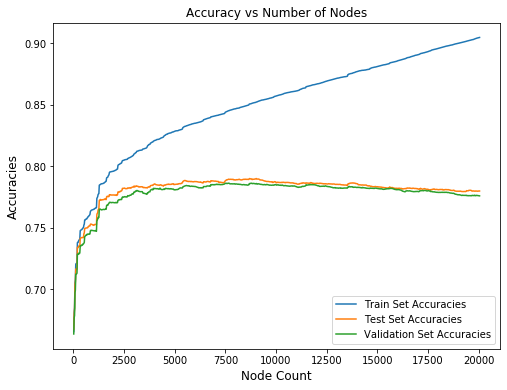

In [7]:
plotTreeAccuracies(nodeCount,trainList,testList,valList,"Accuracy vs Number of Nodes","lower right")

## PART B

In [8]:
st = time()
accList = clf.prune(trainX,trainY,testX,testY,valX,valY)
print("Tree pruned in:",time()-st,"secs")

Tree pruned in: 6.558442831039429 secs


In [9]:
predTrain = clf.predict(trainX)
trainScore = clf.score(predTrain,trainY)
print("Training Score on pruned tree:",trainScore)
predTest = clf.predict(testX)
testScore = clf.score(predTest,testY)
print("Testing Score on pruned tree:",testScore)
predVal = clf.predict(valX)
valScore = clf.score(predVal,valY)
print("Validation Score on pruned tree:",valScore)

Training Score on pruned tree: 0.8321202849504736
Testing Score on pruned tree: 0.7976449863242316
Validation Score on pruned tree: 0.8245874281475988


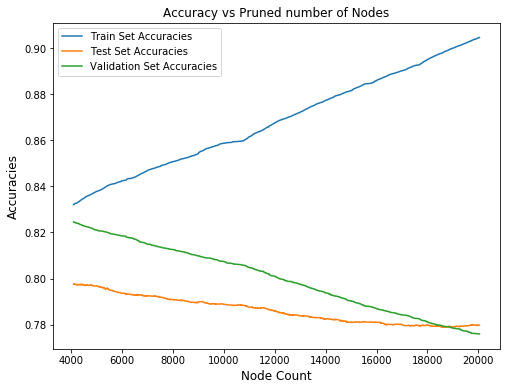

In [10]:
accList = np.array(accList)
plotTreeAccuracies(accList[:,0],accList[:,1],accList[:,2],accList[:,3],"Accuracy vs Pruned number of Nodes","upper left")

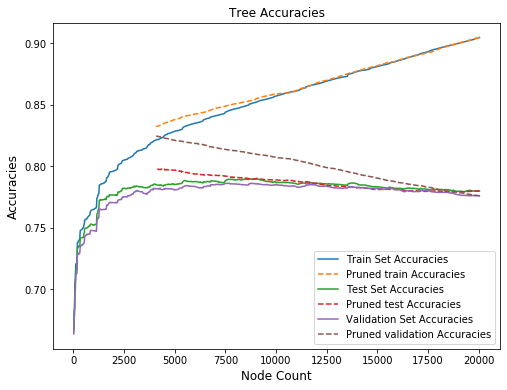

In [19]:
y = np.array(trainList)
plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(nodeCount,y,label="Train Set Accuracies")
ax.plot(accList[:,0],accList[:,1],label="Pruned train Accuracies",linestyle="--")
y = np.array(testList)
ax.plot(nodeCount,y,label="Test Set Accuracies")
ax.plot(accList[:,0],accList[:,2],label="Pruned test Accuracies",linestyle="--")
y = np.array(valList)
ax.plot(nodeCount,y,label="Validation Set Accuracies")
ax.plot(accList[:,0],accList[:,3],label="Pruned validation Accuracies",linestyle="--")
plt.title("Tree Accuracies")
ax.set_xlabel("Node Count",fontsize=12)
ax.set_ylabel("Accuracies",fontsize=12)
plt.legend(loc="lower right")
plt.show()

## PART C

In [38]:
estimatorList = [50,150,250,350,450]
minSamplesList = [2,4,6,8,10]
maxFeaturesList = [0.1,0.3,0.5,0.7,0.9,1]

paraList = list(itertools.product(estimatorList,minSamplesList,maxFeaturesList))
data = (trainX,trainY)

try:
    st = time()
    pickle_in = open("gridSearch.pickle","rb")
    oobList = pickle.load(pickle_in)
    print("Grid search without cross validation",time()-st)
except:
    st = time()
    oobList = Parallel(n_jobs=-1)(delayed(oobScore)(i,data) for i in paraList)
    print("Grid search without cross validation",time()-st)
    with open("gridSearch.pickle","wb") as f:
        pickle.dump(oobList, f)

Grid search without cross validation 0.13571643829345703


In [39]:
oobList = np.array(oobList)
index = np.where(oobList[:,1]==max(oobList[:,1]))[0][0]
print("Optimal n_estimators:",oobList[index][0][0])
print("Optimal max_features:",oobList[index][0][2])
print("Optimal min_samples_splt:",oobList[index][0][1])
best_max_features = oobList[index][0][2]
best_min_samples_split = oobList[index][0][1]
best_n_estimators = oobList[index][0][0]

Optimal n_estimators: 350
Optimal max_features: 0.1
Optimal min_samples_splt: 10


In [40]:
rf = RandomForestClassifier(criterion='entropy',n_estimators=best_n_estimators,max_features=best_max_features,min_samples_split=best_min_samples_split,oob_score=True,n_jobs=-1)
st = time()
rf.fit(trainX,trainY)
print("Time",time()-st)
print("Out of bag score:",rf.oob_score_)
print("Training score:",rf.score(trainX,trainY))
print("Testing score:",rf.score(testX,testY))
print("Validation score:",rf.score(valX,valY))

Time 153.2122519016266
Out of bag score: 0.8093273376292244
Training score: 0.8764235934047255
Testing score: 0.8083074498168837
Validation score: 0.8068329315779714


In [41]:
rf = RandomForestClassifier(criterion='entropy',oob_score=True,n_jobs=-1)
parameters = {'n_estimators':[50,150,250,350,450],'max_features':[0.1,0.3,0.5,0.7,0.9,1],'min_samples_split':[2,4,6,8,10]}
gridSearchclf = GridSearchCV(rf, parameters,n_jobs=-1,scoring=scorer,cv=3)

In [42]:
try:
    st = time()
    pickle_in = open("gridCV3.pickle","rb")
    gridSearchclf = pickle.load(pickle_in)
    print("Grid Search with cross validation:",time()-st)
except:
    st = time()
    gridSearchclf.fit(trainX,trainY)
    print("Grid Search with cross validation:",time()-st)
    with open("gridCV3.pickle","wb") as f:
        pickle.dump(gridSearchclf, f)
print(gridSearchclf.best_params_)
best_max_features = gridSearchclf.best_params_['max_features']
best_min_samples_split = gridSearchclf.best_params_['min_samples_split']
best_n_estimators = gridSearchclf.best_params_['n_estimators']

/home/kartik/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kartik/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Grid Search with cross validation: 5.009390592575073
{'max_features': 0.1, 'min_samples_split': 10, 'n_estimators': 450}


/home/kartik/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [43]:
rf = RandomForestClassifier(criterion='entropy',n_estimators=best_n_estimators,max_features=best_max_features,min_samples_split=best_min_samples_split,oob_score=True,n_jobs=-1)
st = time()
rf.fit(trainX,trainY)
print("Time",time()-st)
print("Out of bag score:",rf.oob_score_)
print("Training score:",rf.score(trainX,trainY))
print("Testing score:",rf.score(testX,testY))
print("Validation score:",rf.score(valX,valY))

Time 190.00242972373962
Out of bag score: 0.810285414058999
Training score: 0.8765472161698576
Testing score: 0.8082147327430347
Validation score: 0.8060912293714074


## PART D

In [44]:
estimatorList = [50,150,250,350,450]
minSamplesList = [2,4,6,8,10]
maxFeaturesList = [0.1,0.3,0.5,0.7,0.9,1]
try:
    st = time()
    pickle_in = open("paramSensitivity350.pickle","rb")
    n_estimators_varied,min_samples_split_varied,max_features_varied = pickle.load(pickle_in)
    print(time()-st)
except:
    st = time()
    n_estimators_varied,min_samples_split_varied,max_features_varied = paramSensitivity(estimatorList,minSamplesList,maxFeaturesList)  
    print(time()-st)
    with open("paramSensitivity350.pickle","wb") as f:
        pickle.dump((n_estimators_varied,min_samples_split_varied,max_features_varied), f)

0.04460287094116211


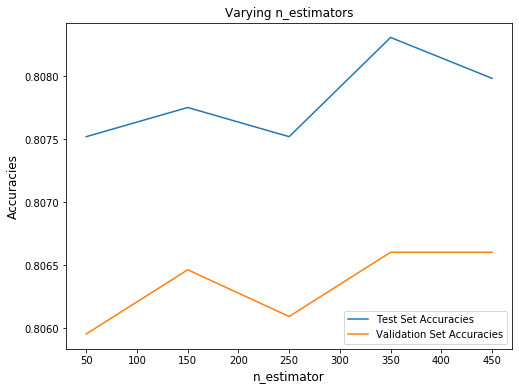

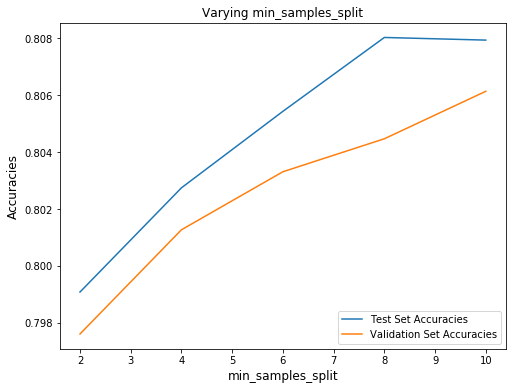

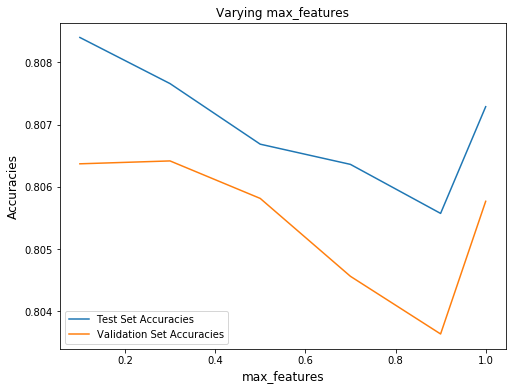

In [45]:
plotForest(estimatorList,n_estimators_varied,"Varying n_estimators","n_estimator","lower right") 
plotForest(minSamplesList,min_samples_split_varied,"Varying min_samples_split","min_samples_split","lower right") 
plotForest(maxFeaturesList,max_features_varied,"Varying max_features","max_features","lower left")